### 1. Importing libraries and data

In [94]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [95]:
# Configure API key 

quandl.ApiConfig.api_key = '52U65YMF3dfAPgxXVRNd'

In [134]:
# Importing the Inflation Rates data of France "RATEINF/CPI_FRA" variable.
# The customer in France is the country most satisfy with our bank

data = quandl.get('RATEINF/CPI_FRA')

In [97]:
data.head(10)

Value
Date             
1990-01-31   66.4
1990-02-28   66.6
1990-03-31   66.7
1990-04-30   67.1
1990-05-31   67.2
1990-06-30   67.2
1990-07-31   67.2
1990-08-31   67.6
1990-09-30   68.1
1990-10-31   68.4

In [98]:
data.shape

(403, 1)

In [99]:
data.columns

Index(['Value'], dtype='object')

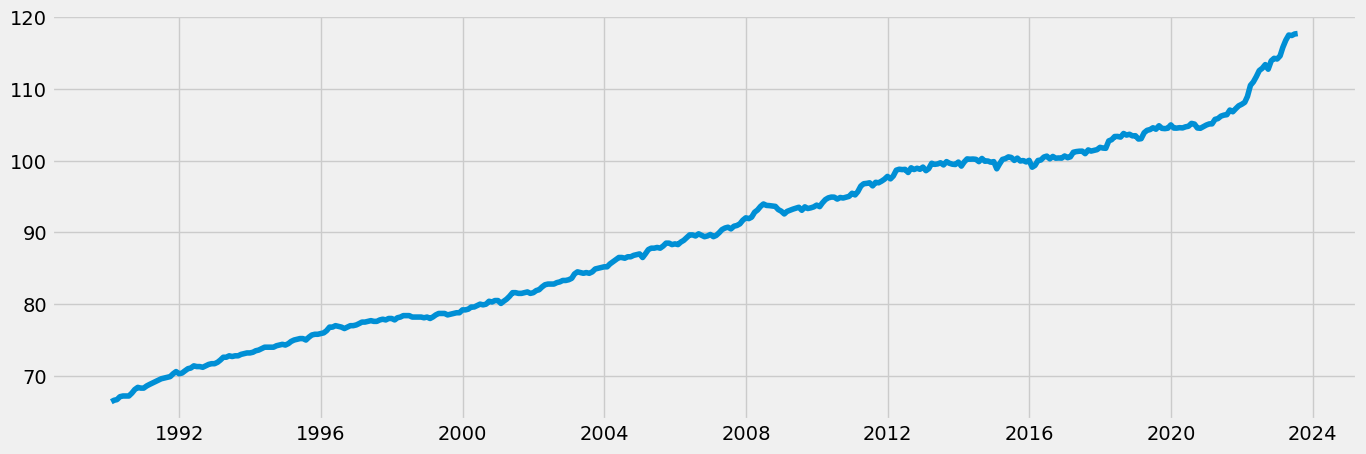

In [100]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [101]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [102]:
data_2.head()

Date  Value
0 1990-01-31   66.4
1 1990-02-28   66.6
2 1990-03-31   66.7
3 1990-04-30   67.1
4 1990-05-31   67.2

In [103]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2023-08-29')]

In [104]:
data_sub.shape

(283, 2)

In [105]:
data_sub.head(10)

Date  Value
120 2000-01-31   79.2
121 2000-02-29   79.3
122 2000-03-31   79.6
123 2000-04-30   79.6
124 2000-05-31   79.8
125 2000-06-30   80.0
126 2000-07-31   79.9
127 2000-08-31   80.0
128 2000-09-30   80.4
129 2000-10-31   80.3

In [106]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

Value
datetime         
2000-01-31   79.2
2000-02-29   79.3
2000-03-31   79.6
2000-04-30   79.6
2000-05-31   79.8

In [107]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [108]:
# Check for missing values.

data.isnull().sum() 

Value    0
dtype: int64

In [109]:
# Check for duplicates.

dups = data.duplicated()
dups.sum()

81

In [110]:
#check for duplicate rows
duplicate_rows = data[dups]

In [111]:
data[dups].head(10)

Value
Date             
1990-06-30   67.2
1990-07-31   67.2
1990-12-31   68.3
1991-12-31   70.3
1992-07-31   71.3
1992-09-30   71.4
1992-12-31   71.7
1993-04-30   72.6
1993-07-31   72.8
1993-08-31   72.8

We could found that duplicate is in Value colume and it is fine. There is no dups.

### 3. Time-series analysis: decomposition

In [115]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='Additive')

In [116]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [117]:
# Plot the separate components

decomposition.plot()
plt.show()

The level and trend seem to be consistent and we could found that still increase till 2023.

### 4. Testing for stationarity

In [118]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.694756
p-value                          0.989733
Number of Lags Used             14.000000
Number of Observations Used    268.000000
Critical Value (1%)             -3.454988
Critical Value (5%)             -2.872386
Critical Value (10%)            -2.572549
dtype: float64


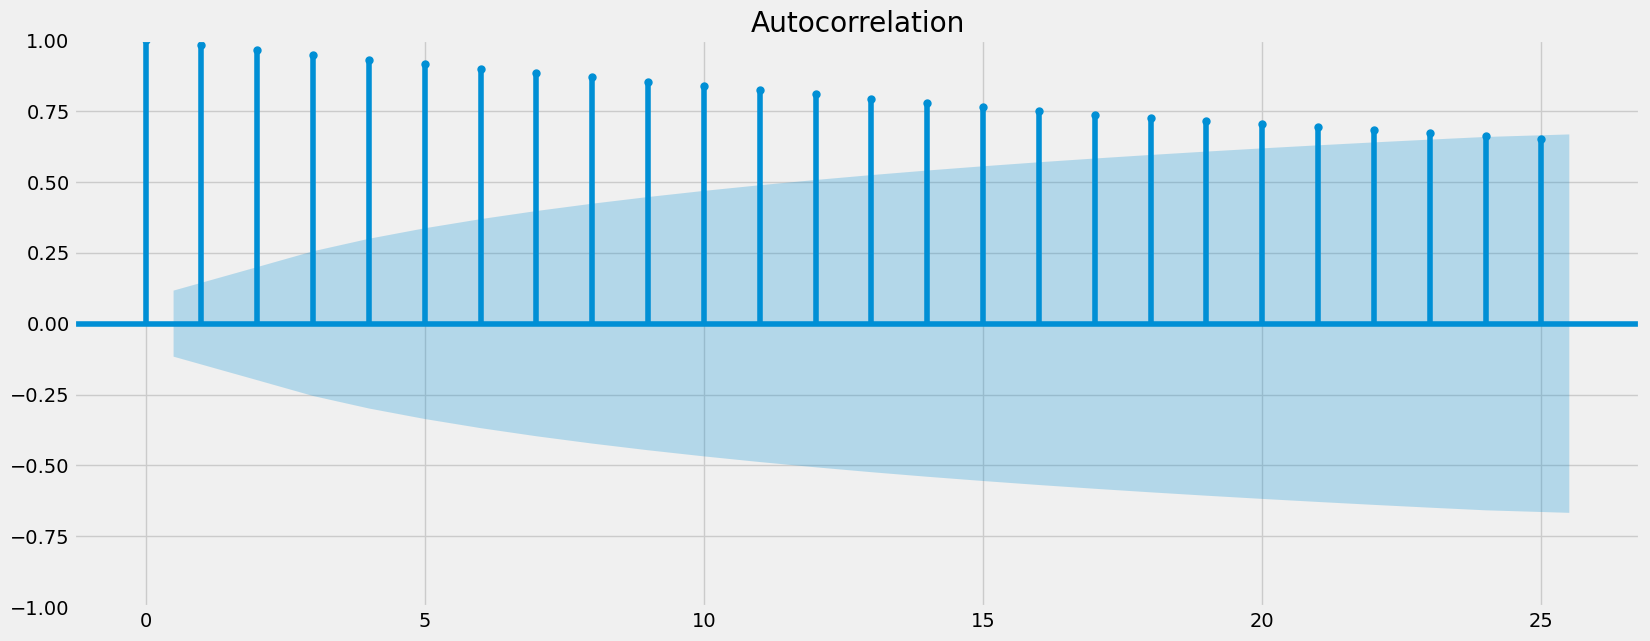

In [119]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

In this case,  I using a significance level of 5 percent.We could found that “Critical Value (5%)” in the results, which, in this case, has a value of -2.872386. This is much smaller than the test statistic, which is 0.694756, which means that I can’t reject the null hypothesis.My data is non-stationary.

### 5. Stationarizing the Federal Reserve Economic Data

In [120]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [121]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [122]:
data_diff.head()

Value
datetime         
2000-02-29    0.1
2000-03-31    0.3
2000-04-30    0.0
2000-05-31    0.2
2000-06-30    0.2

In [123]:
data_diff.columns

Index(['Value'], dtype='object')

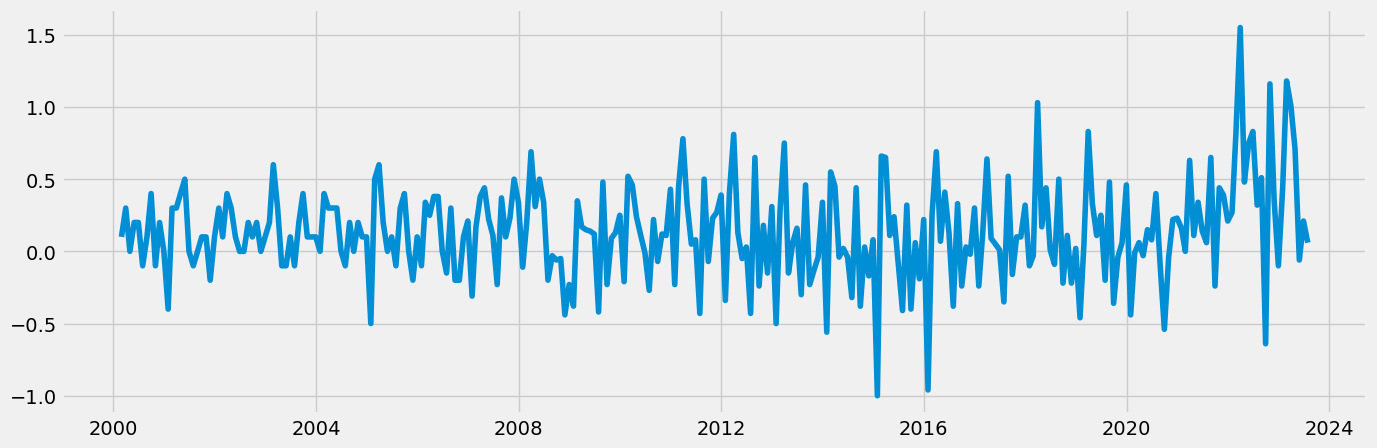

In [124]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [125]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.924274
p-value                          0.320729
Number of Lags Used             13.000000
Number of Observations Used    268.000000
Critical Value (1%)             -3.454988
Critical Value (5%)             -2.872386
Critical Value (10%)            -2.572549
dtype: float64


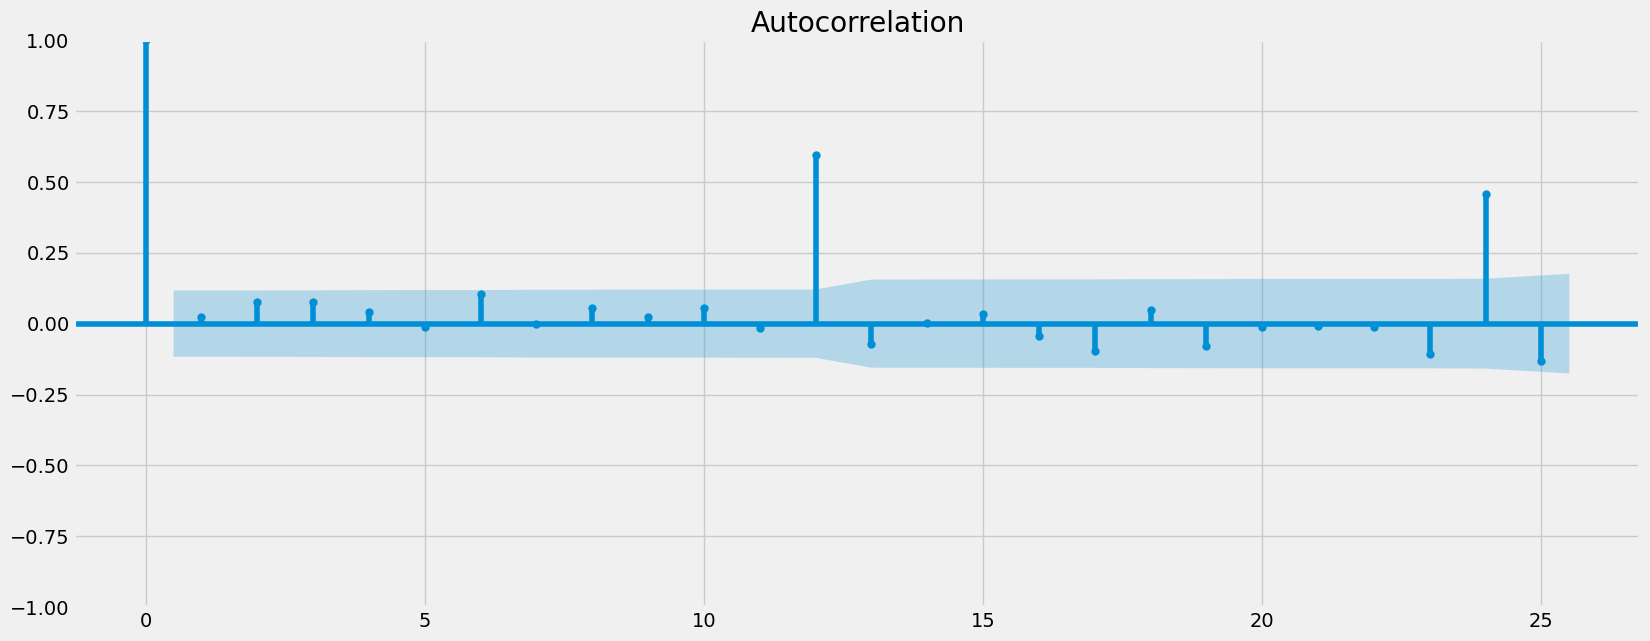

In [126]:
plot_acf(data_diff)
plt.show()

In [127]:
data_diff2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [128]:
data_diff2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [129]:
data_diff2.head()

Value
datetime         
2000-03-31    0.2
2000-04-30   -0.3
2000-05-31    0.2
2000-06-30    0.0
2000-07-31   -0.3

In [130]:
# Check for missing values (you shouldn't have any)

data_diff2.isnull().sum() 

Value    0
dtype: int64

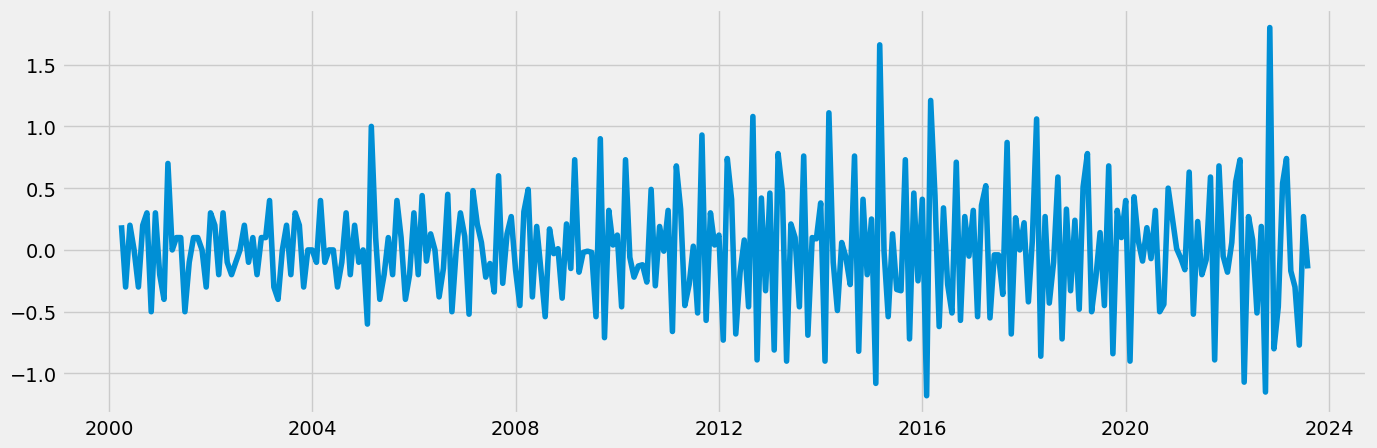

In [131]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [132]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.717723e+00
p-value                        9.728487e-17
Number of Lags Used            1.100000e+01
Number of Observations Used    2.690000e+02
Critical Value (1%)           -3.454896e+00
Critical Value (5%)           -2.872345e+00
Critical Value (10%)          -2.572528e+00
dtype: float64


#### The Test Statistic now falls below the Critical Value at all levels, accompanied by a significantly low p-value well below 0.5. This outcome allows us to reject the null hypothesis and deem the time series as stationary.

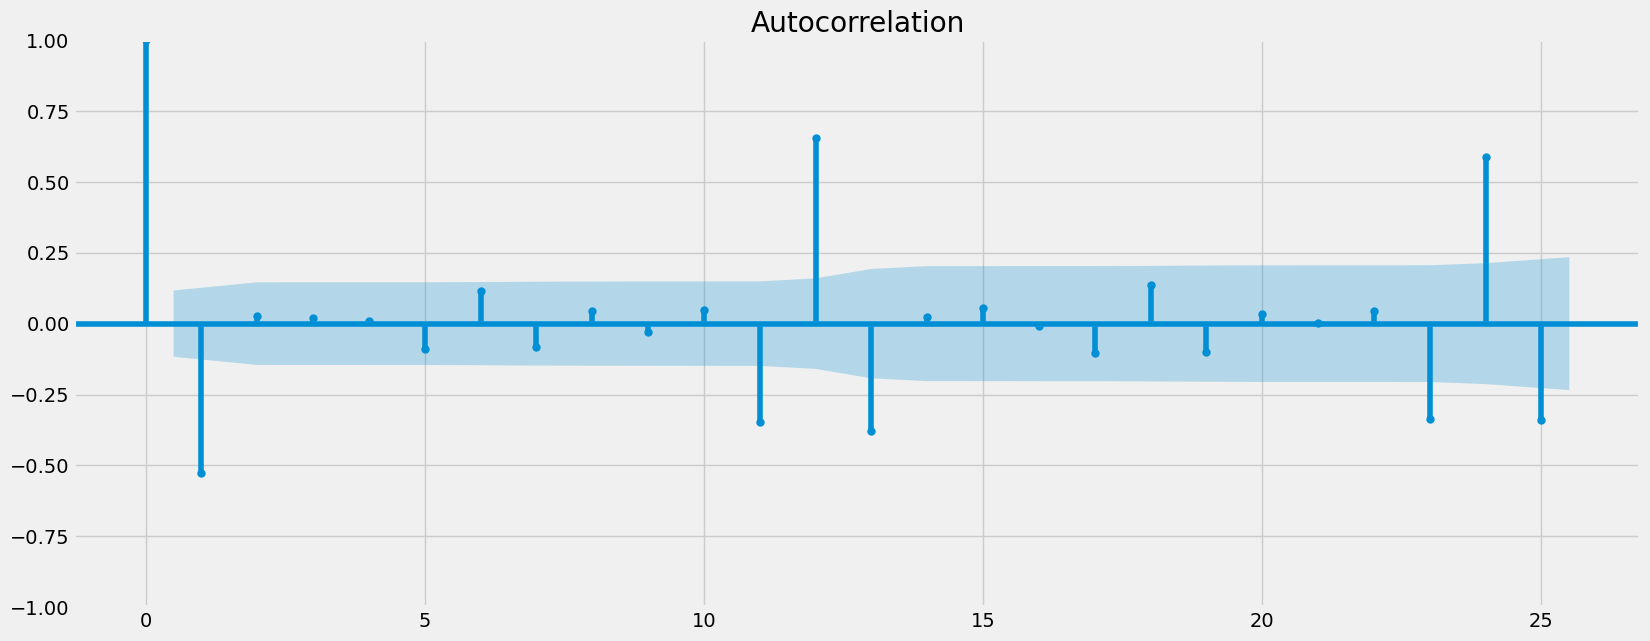

In [133]:
plot_acf(data_diff2)
plt.show()

###The autocorrelation plot shows significantly fewer autocorrelation patterns, indicating that there's no need for another round of differencing to make the data stationary, especially considering there are less than 10 lags.